In [2]:
# CELL 1: DATA COLLECTION & CALCULATION WITH USER INPUT
print("TECHNICAL ANALYSIS DASHBOARD")
print("="*50)

import yfinance as yf
import pandas as pd
import numpy as np

# Default stocks
default_stocks = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']

choice = input(f"\nDefault stocks: {', '.join(default_stocks)} \nOptions: \n1. Use default stocks \n2. Enter your own stocks \n3. Analyze single stock \nEnter choice (1, 2, or 3): ").strip()

if choice == '2':
    # User enters their own stocks
    user_input = input("Enter stock symbols (comma-separated, e.g., AAPL,MSFT,GOOGL): ")
    stock_list = [s.strip().upper() for s in user_input.split(',') if s.strip()]
    print(f"Selected stocks: {', '.join(stock_list)}")

elif choice == '3':
    # Single stock analysis
    single_stock = input("Enter stock symbol (e.g., AAPL): ").strip().upper()
    stock_list = [single_stock]

else:
    # Use default stocks
    stock_list = default_stocks
    print(f"Using default stocks: {', '.join(stock_list)}")

# Also fetch S&P 500 for comparison
stock_list.append('SPY')  # Add SPY for market comparison
print(f"Will analyze: {', '.join(stock_list)}")

# Dictionary to store all data
all_data = {}
all_info = {}
failed_stocks = []

for stock in stock_list:
    try:
        ticker = yf.Ticker(stock)

        # Get 1 year of historical data
        hist_data = ticker.history(period="1y")

        if hist_data.empty:
            print(f"No data for {stock}")
            failed_stocks.append(stock)
            continue

        # Get company info
        info_data = ticker.info

        all_data[stock] = hist_data
        all_info[stock] = info_data

    except Exception as e:
        print(f"Error fetching {stock}: {str(e)[:50]}...")
        failed_stocks.append(stock)

# Remove failed stocks from list
stock_list = [s for s in stock_list if s not in failed_stocks]

if not stock_list:
    # Create dummy data for demo
    print ("error")

# Dictionary to store calculated indicators
indicators = {}

for stock in stock_list:

    hist = all_data[stock].copy()

    # 1. Simple Moving Averages
    hist['SMA_20'] = hist['Close'].rolling(window=20).mean()
    hist['SMA_50'] = hist['Close'].rolling(window=50).mean()

    # 2. Exponential Moving Average
    hist['EMA_20'] = hist['Close'].ewm(span=20, adjust=False).mean()

    # 3. Bollinger Bands
    hist['BB_Middle'] = hist['Close'].rolling(window=20).mean()
    hist['BB_Upper'] = hist['BB_Middle'] + (hist['Close'].rolling(20).std() * 2)
    hist['BB_Lower'] = hist['BB_Middle'] - (hist['Close'].rolling(20).std() * 2)

    # 4. Daily Returns
    hist['Daily_Return'] = hist['Close'].pct_change()

    # 5. Cumulative Returns
    hist['Cumulative_Return'] = (1 + hist['Daily_Return']).cumprod()

    # 6. Relative Strength Index (RSI)
    delta = hist['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    hist['RSI'] = 100 - (100 / (1 + rs))

    # 7. MACD
    hist['EMA_12'] = hist['Close'].ewm(span=12, adjust=False).mean()
    hist['EMA_26'] = hist['Close'].ewm(span=26, adjust=False).mean()
    hist['MACD'] = hist['EMA_12'] - hist['EMA_26']
    hist['Signal_Line'] = hist['MACD'].ewm(span=9, adjust=False).mean()
    hist['MACD_Histogram'] = hist['MACD'] - hist['Signal_Line']

    indicators[stock] = hist


# ========== CALCULATE BETA (for non-SPY stocks vs SPY) ==========
if 'SPY' in stock_list and len(stock_list) > 1:

    spy_returns = indicators['SPY']['Daily_Return']

    for stock in stock_list:
        if stock != 'SPY':
            stock_returns = indicators[stock]['Daily_Return']

            # Align dates
            aligned_returns = pd.DataFrame({
                'Stock': stock_returns,
                'SPY': spy_returns
            }).dropna()

            if len(aligned_returns) >= 60:
                # Calculate rolling beta
                aligned_returns['Covariance'] = aligned_returns['Stock'].rolling(60).cov(aligned_returns['SPY'])
                aligned_returns['SPY_Variance'] = aligned_returns['SPY'].rolling(60).var()
                aligned_returns['Beta'] = aligned_returns['Covariance'] / aligned_returns['SPY_Variance']

                # Add beta to indicators
                indicators[stock] = indicators[stock].join(aligned_returns[['Beta']], how='left')
                current_beta = aligned_returns['Beta'].iloc[-1] if not aligned_returns['Beta'].isna().all() else None

                if current_beta is not None:
                    print(f"  {stock} Beta: {current_beta:.2f}")
                else:
                    print(f"  {stock}: Insufficient data for Beta")

# Create normalized data for comparison (all stocks start at 100)
normalized_data = pd.DataFrame()

for stock in stock_list:
    if stock in indicators:
        normalized_data[stock] = indicators[stock]['Close'] / indicators[stock]['Close'].iloc[0] * 100

# Calculate performance metrics
performance_summary = {}

for stock in stock_list:
    if stock in indicators:
        hist = indicators[stock]

        # Basic metrics
        current_price = hist['Close'].iloc[-1]
        total_return = (hist['Cumulative_Return'].iloc[-1] - 1) * 100
        volatility = hist['Daily_Return'].std() * np.sqrt(252) * 100
        sharpe = (hist['Daily_Return'].mean() / hist['Daily_Return'].std() * np.sqrt(252)) if hist['Daily_Return'].std() > 0 else 0

        # Technical indicators
        current_rsi = hist['RSI'].iloc[-1] if 'RSI' in hist.columns and not pd.isna(hist['RSI'].iloc[-1]) else None
        macd_signal = hist['MACD_Histogram'].iloc[-1] if 'MACD_Histogram' in hist.columns else None

        # Get company info
        info = all_info.get(stock, {})

        performance_summary[stock] = {
            'Current_Price': current_price,
            'Total_Return_%': total_return,
            'Volatility_%': volatility,
            'Sharpe_Ratio': sharpe,
            'RSI': current_rsi,
            'MACD_Signal': macd_signal,
            'Beta': hist['Beta'].iloc[-1] if 'Beta' in hist.columns and not hist['Beta'].isna().all() else None,
            'Market_Cap': info.get('marketCap', None),
            'PE_Ratio': info.get('trailingPE', None),
            'Dividend_Yield_%': info.get('dividendYield', 0) * 100 if info.get('dividendYield') else 0,
            'SMA_20': hist['SMA_20'].iloc[-1] if not pd.isna(hist['SMA_20'].iloc[-1]) else None,
            'Above_SMA_20': (current_price > hist['SMA_20'].iloc[-1]) if not pd.isna(hist['SMA_20'].iloc[-1]) else None
        }


# Show quick summary
print("QUICK PERFORMANCE SUMMARY:")
print("-" * 40)
for stock in [s for s in stock_list if s != 'SPY']:
    if stock in performance_summary:
        perf = performance_summary[stock]
        print(f"{stock}: {perf['Total_Return_%']:+.1f}% | Vol: {perf['Volatility_%']:.1f}% | " +
              f"Sharpe: {perf['Sharpe_Ratio']:.2f}")

if 'SPY' in performance_summary:
    spy_perf = performance_summary['SPY']
    print(f"MARKET (SPY): {spy_perf['Total_Return_%']:+.1f}% return")


TECHNICAL ANALYSIS DASHBOARD
Will analyze: ERT, SPY


$ERT: possibly delisted; no price data found  (period=1y)


No data for ERT
QUICK PERFORMANCE SUMMARY:
----------------------------------------
MARKET (SPY): +16.5% return


PERFORMANCE SUMMARY TABLE:
--------------------------------------------------------------------------------
Stock    Price      Return %   Vol %      Sharpe     Beta     RSI     
--------------------------------------------------------------------------------


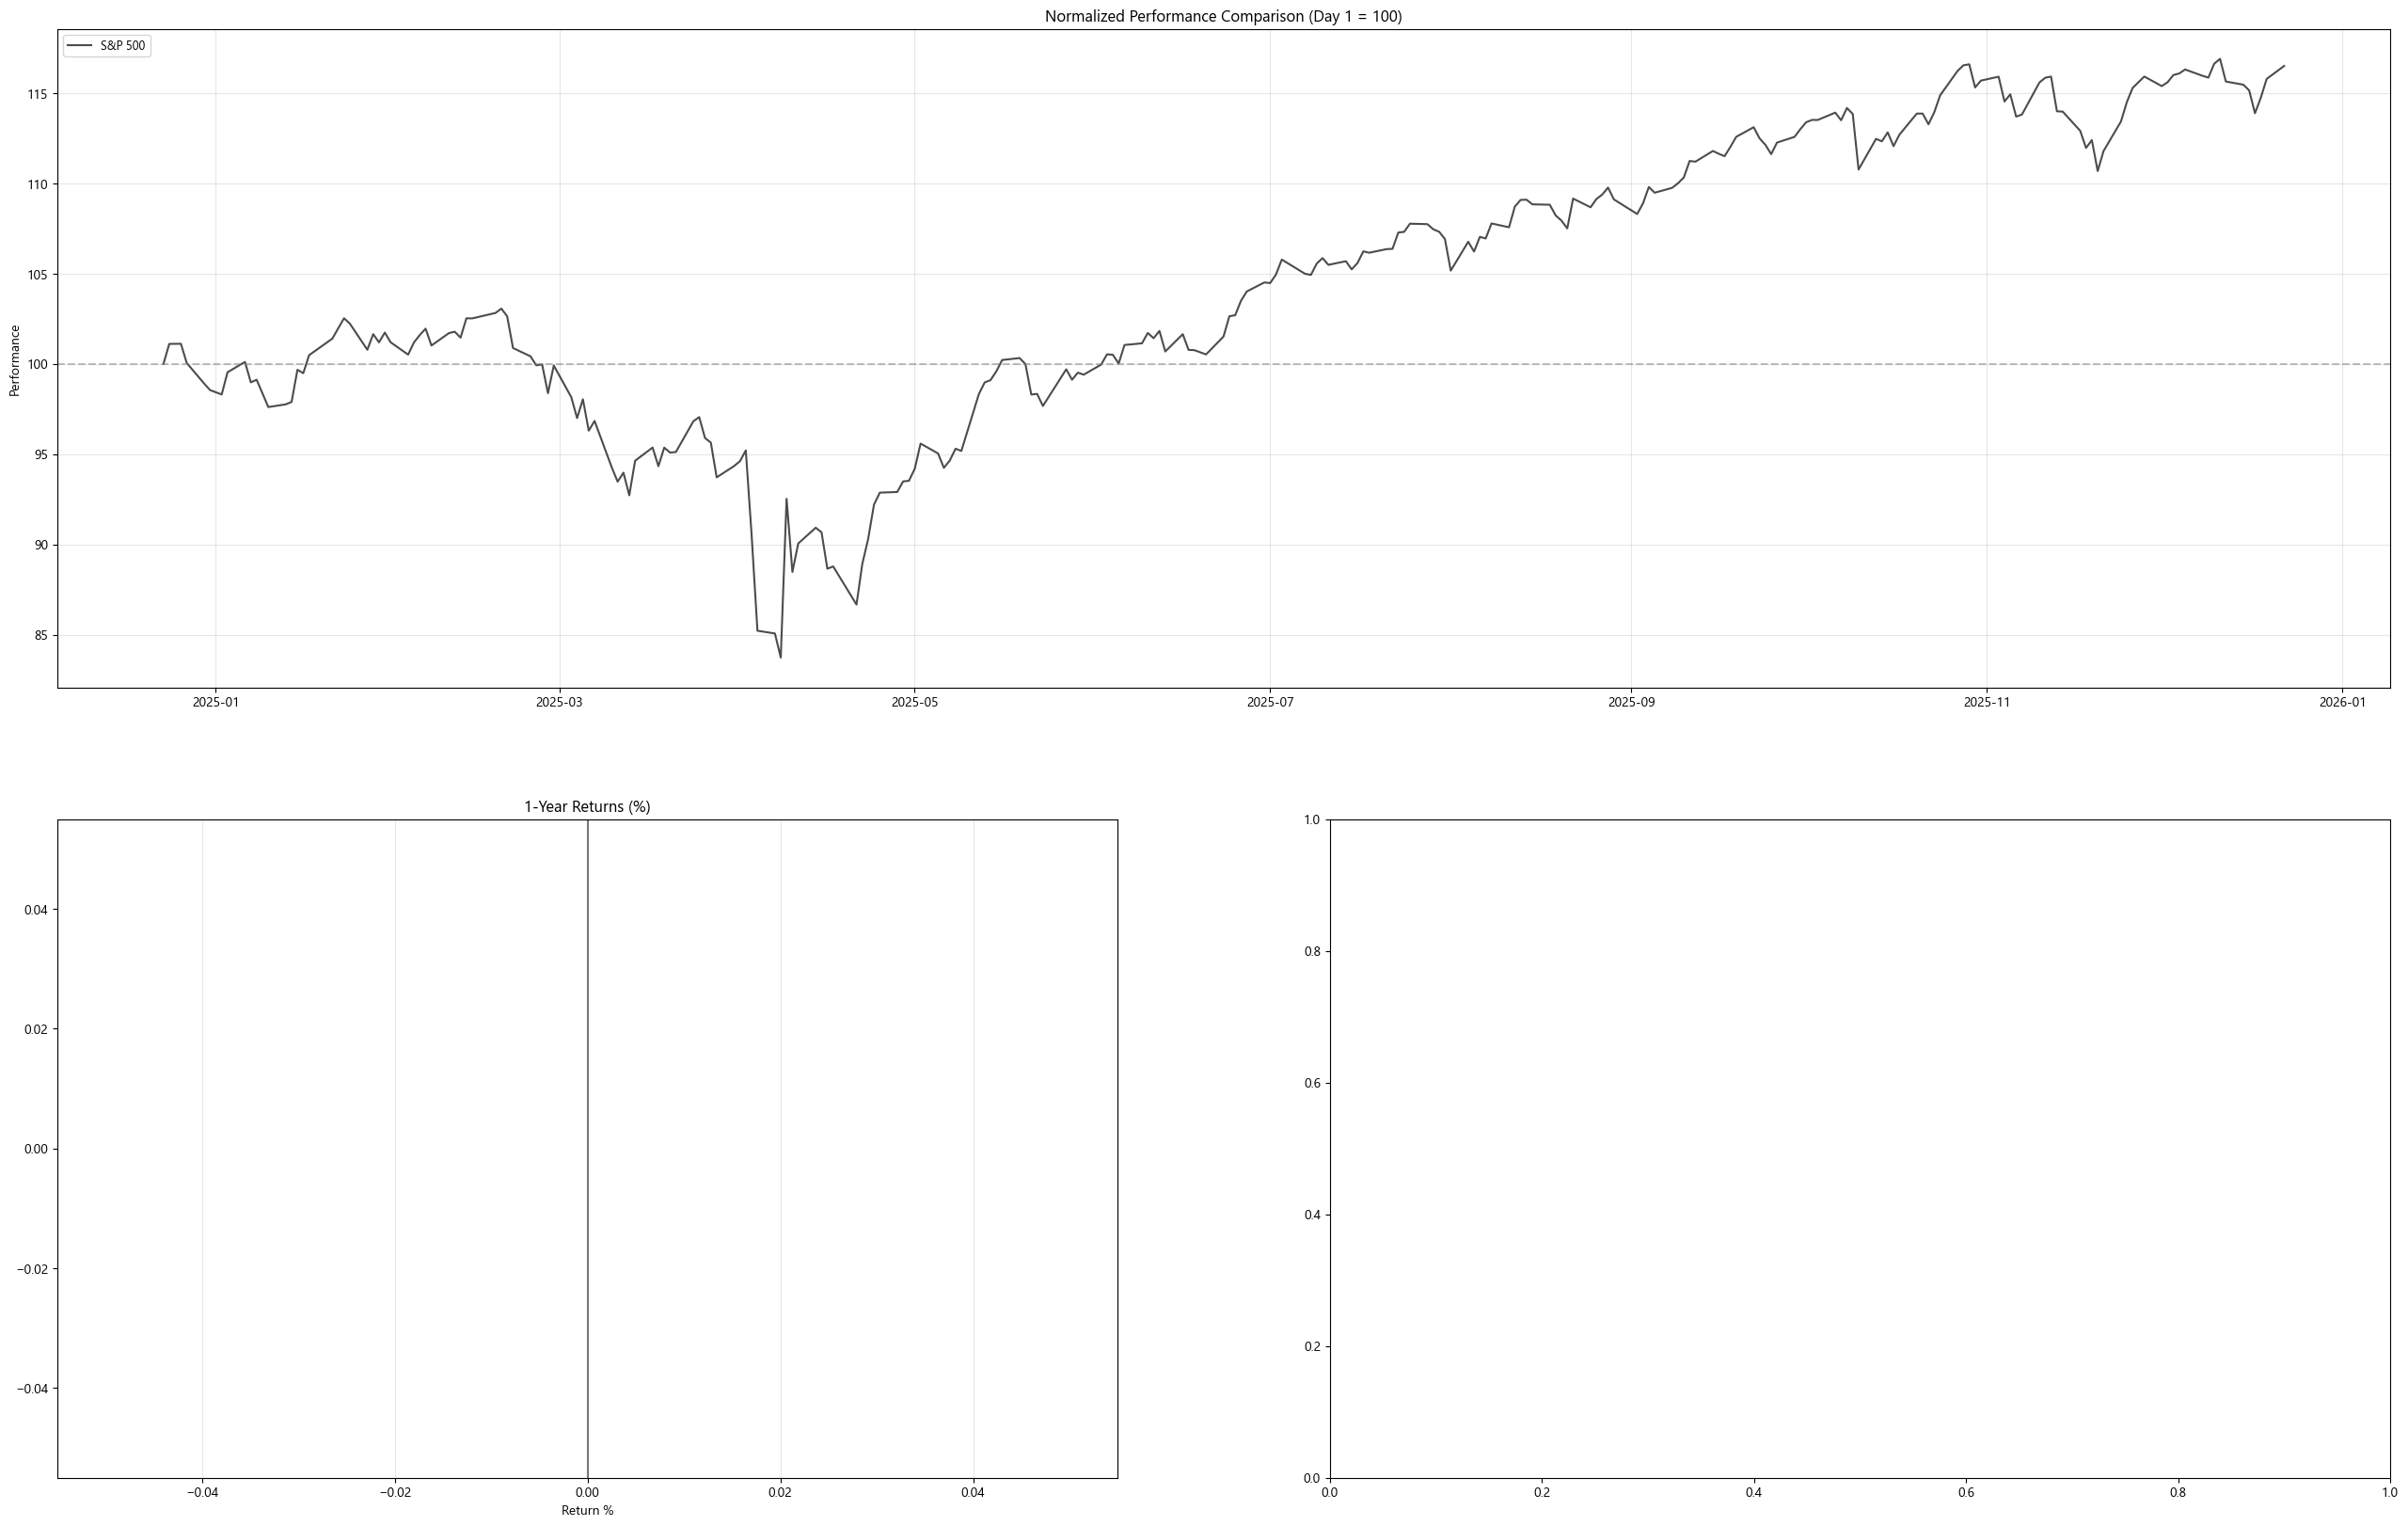

In [3]:
# CELL 2: VISUALIZATION DASHBOARD

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams['font.sans-serif'] = ['Segoe UI Emoji', 'DejaVu Sans']
import matplotlib.dates as mdates

# Check if we have data from Cell 1
if 'stock_list' not in locals() or len(stock_list) == 0:
    print("ERROR: Run Cell 1 first to collect data!")

# CREATE DASHBOARD
# Determine dashboard layout based on number of stocks
n_stocks = len([s for s in stock_list if s != 'SPY'])
main_stocks = [s for s in stock_list if s != 'SPY']

if n_stocks == 1:
    # Single stock: Detailed analysis
    fig = plt.figure(figsize=(18, 12))
    stock = main_stocks[0]

    # Create grid
    gs = gridspec.GridSpec(3, 4, figure=fig, hspace=0.3, wspace=0.3)

    # 1. Price with Indicators (top left, 2 columns)
    ax1 = fig.add_subplot(gs[0, :2])
    hist = indicators[stock]
    ax1.plot(hist.index, hist['Close'], label='Close', color='black', linewidth=2)
    ax1.plot(hist.index, hist['SMA_20'], label='SMA 20', color='blue', linewidth=1, alpha=0.8)
    ax1.plot(hist.index, hist['EMA_20'], label='EMA 20', color='red', linewidth=1, alpha=0.8)
    ax1.fill_between(hist.index, hist['BB_Upper'], hist['BB_Lower'], alpha=0.1, color='gray')
    ax1.set_title(f'{stock} - Price with Indicators', fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # 2. Normalized vs SPY (top right)
    ax2 = fig.add_subplot(gs[0, 2:])
    if 'SPY' in normalized_data.columns:
        ax2.plot(normalized_data.index, normalized_data[stock], label=stock, linewidth=2)
        ax2.plot(normalized_data.index, normalized_data['SPY'], label='S&P 500', linewidth=2, alpha=0.7)
        ax2.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
        ax2.set_title(f'{stock} vs Market (Normalized)', fontweight='bold')
        ax2.set_ylabel('Performance (Day 1 = 100)')
        ax2.legend()
        ax2.grid(True, alpha=0.3)

    # 3. Bollinger Bands (middle left)
    ax3 = fig.add_subplot(gs[1, :2])
    last_60 = hist.tail(60)
    ax3.plot(last_60.index, last_60['Close'], label='Close', color='black', linewidth=2)
    ax3.plot(last_60.index, last_60['BB_Upper'], label='Upper Band', color='red', linewidth=1, linestyle='--')
    ax3.plot(last_60.index, last_60['BB_Lower'], label='Lower Band', color='green', linewidth=1, linestyle='--')
    ax3.fill_between(last_60.index, last_60['BB_Upper'], last_60['BB_Lower'], alpha=0.1, color='gray')
    ax3.set_title('Bollinger Bands (Last 60 Days)', fontweight='bold')
    ax3.set_ylabel('Price ($)')
    ax3.legend(loc='upper left', fontsize=9)
    ax3.grid(True, alpha=0.3)

    # 4. Daily Returns Distribution (middle right)
    ax4 = fig.add_subplot(gs[1, 2])
    returns = hist['Daily_Return'].dropna() * 100
    ax4.hist(returns, bins=30, edgecolor='black', alpha=0.7, color='steelblue')
    ax4.axvline(x=returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.2f}%')
    ax4.set_title('Daily Returns Distribution', fontweight='bold')
    ax4.set_xlabel('Return (%)')
    ax4.set_ylabel('Frequency')
    ax4.legend(fontsize=8)
    ax4.grid(True, alpha=0.3)

    # 5. RSI (bottom left)
    ax5 = fig.add_subplot(gs[2, 0])
    if 'RSI' in hist.columns:
        rsi_data = hist['RSI'].dropna().tail(60)
        ax5.plot(rsi_data.index, rsi_data, color='purple', linewidth=2)
        ax5.axhline(y=70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
        ax5.axhline(y=30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
        ax5.axhline(y=50, color='gray', linestyle='-', alpha=0.3)
        ax5.set_title('RSI (Last 60 Days)', fontweight='bold')
        ax5.set_ylabel('RSI')
        ax5.set_ylim(0, 100)
        ax5.legend(fontsize=8)
        ax5.grid(True, alpha=0.3)
        ax5.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax5.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax5.tick_params(axis='x', rotation=45)

    # 6. MACD (bottom middle)
    ax6 = fig.add_subplot(gs[2, 1])
    if 'MACD' in hist.columns:
        macd_data = hist[['MACD', 'Signal_Line']].tail(60)
        ax6.plot(macd_data.index, macd_data['MACD'], label='MACD', color='blue', linewidth=2)
        ax6.plot(macd_data.index, macd_data['Signal_Line'], label='Signal', color='red', linewidth=1)
        ax6.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        ax6.set_title('MACD (Last 60 Days)', fontweight='bold')
        ax6.set_ylabel('MACD')
        ax6.legend(fontsize=8)
        ax6.grid(True, alpha=0.3)
        ax6.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
        ax6.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
        ax6.tick_params(axis='x', rotation=45)

    # 7. Volume (bottom right)
    ax7 = fig.add_subplot(gs[2, 2])
    volume_data = hist['Volume'].tail(60) / 1e6  # Convert to millions
    colors = ['red' if vol > volume_data.mean() * 1.5 else 'orange' if vol > volume_data.mean() else 'green'
              for vol in volume_data]
    ax7.bar(volume_data.index, volume_data, color=colors, alpha=0.7, width=1)
    ax7.axhline(y=volume_data.mean(), color='blue', linestyle='--', label=f'Avg: {volume_data.mean():.1f}M')
    ax7.set_title('Volume (Last 60 Days)', fontweight='bold')
    ax7.set_ylabel('Volume (Millions)')
    ax7.legend(fontsize=8)
    ax7.grid(True, alpha=0.3)
    ax7.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
    ax7.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
    ax7.tick_params(axis='x', rotation=45)

    # 8. Performance Summary (bottom far right)
    ax8 = fig.add_subplot(gs[:, 3])
    ax8.axis('off')

    perf = performance_summary.get(stock, {})
    summary_text = f"""
{stock} SUMMARY

Price: ${perf.get('Current_Price', 0):.2f}
Return: {perf.get('Total_Return_%', 0):+.1f}%
Volatility: {perf.get('Volatility_%', 0):.1f}%
Sharpe: {perf.get('Sharpe_Ratio', 0):.2f}

TECHNICALS
RSI: {perf.get('RSI', 'N/A'):.1f}
Beta: {perf.get('Beta', 'N/A'):.2f}
Above SMA 20: {'YES' if perf.get('Above_SMA_20') else 'NO'}

VALUATION
PE Ratio: {perf.get('PE_Ratio', 'N/A'):.2f}
Div Yield: {perf.get('Dividend_Yield_%', 0):.2f}%
"""
    ax8.text(0.01, 0.05, summary_text, fontsize=20, family='monospace',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

else:
    # Multiple stocks: Comparison dashboard
    fig = plt.figure(figsize=(32, 20))

    # 1. Normalized Comparison (top)
    ax1 = plt.subplot(2, 2, (1, 2))  # Takes top 2 columns
    colors = cm.tab10(np.linspace(0, 1, len(main_stocks)))

    for i, stock in enumerate(main_stocks):
        if stock in normalized_data.columns:
            ax1.plot(normalized_data.index, normalized_data[stock],
                     color=colors[i], linewidth=2, label=stock)

    if 'SPY' in normalized_data.columns:
        ax1.plot(normalized_data.index, normalized_data['SPY'],
                 color='black', linewidth=1.5, alpha=0.7, label='S&P 500')

    ax1.axhline(y=100, color='gray', linestyle='--', alpha=0.5)
    ax1.set_title('Normalized Performance Comparison (Day 1 = 100)', fontweight='bold')
    ax1.set_ylabel('Performance')
    ax1.legend(loc='upper left', fontsize=9)
    ax1.grid(True, alpha=0.3)

    # 2. Returns Bar Chart (top right)
    ax2 = plt.subplot(2, 2, 3)
    returns_data = []
    labels = []
    colors_bar = []

    for stock in main_stocks:
        if stock in performance_summary:
            perf = performance_summary[stock]
            returns_data.append(perf.get('Total_Return_%', 0))
            labels.append(stock)
            colors_bar.append('green' if perf.get('Total_Return_%', 0) >= 0 else 'red')

    bars = ax2.barh(labels, returns_data, color=colors_bar, alpha=0.7)
    ax2.axvline(x=0, color='black', linestyle='-', alpha=0.5)

    # Add value labels
    for bar, val in zip(bars, returns_data):
        ax2.text(val + (0.5 if val >= 0 else -1), bar.get_y() + bar.get_height()/2,
                 f'{val:+.1f}%', va='center', fontsize=9,
                 color='black' if abs(val) < 10 else 'white')

    ax2.set_title('1-Year Returns (%)', fontweight='bold')
    ax2.set_xlabel('Return %')
    ax2.grid(True, alpha=0.3, axis='x')

    # 3. Risk-Return Scatter (bottom left)
    ax3 = plt.subplot(2, 2, 4)

    scatter_data = []
    for stock in main_stocks:
        if stock in performance_summary:
            perf = performance_summary[stock]
            scatter_data.append({
                'stock': stock,
                'return': perf.get('Total_Return_%', 0),
                'risk': perf.get('Volatility_%', 0),
                'sharpe': perf.get('Sharpe_Ratio', 0)
            })

    if scatter_data:
        df_scatter = pd.DataFrame(scatter_data)

        # Create scatter plot
        scatter = ax3.scatter(df_scatter['risk'], df_scatter['return'],
                              c=df_scatter['sharpe'], cmap='RdYlGn',
                              s=100, alpha=0.7, edgecolors='black')

        # Add labels
        for i, row in df_scatter.iterrows():
            ax3.annotate(row['stock'], (row['risk'], row['return']),
                         xytext=(5, 5), textcoords='offset points',
                         fontsize=9, fontweight='bold')

        ax3.set_xlabel('Volatility (Risk) %', fontsize=10)
        ax3.set_ylabel('Return %', fontsize=10)
        ax3.set_title('Risk-Return Profile', fontweight='bold')
        ax3.grid(True, alpha=0.3)

        # Add colorbar for Sharpe ratio
        cbar = plt.colorbar(scatter, ax=ax3)
        cbar.set_label('Sharpe Ratio', fontsize=9)

    # 4. Summary Table (bottom right - but we'll create a separate area)
    # Instead, let's print a summary
    print("PERFORMANCE SUMMARY TABLE:")
    print("-" * 80)
    print(f"{'Stock':<8} {'Price':<10} {'Return %':<10} {'Vol %':<10} {'Sharpe':<10} {'Beta':<8} {'RSI':<8}")
    print("-" * 80)

    for stock in main_stocks:
        if stock in performance_summary:
            perf = performance_summary[stock]
            print(f"{stock:<8} ${perf.get('Current_Price', 0):<9.2f} "
                  f"{perf.get('Total_Return_%', 0):<+9.1f}% "
                  f"{perf.get('Volatility_%', 0):<9.1f} "
                  f"{perf.get('Sharpe_Ratio', 0):<9.2f} "
                  f"{perf.get('Beta', 'N/A'):<8.2f}"
                  f"{perf.get('RSI', 'N/A'):<8.1f}")

plt.show()